In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, recall_score
import matplotlib.pyplot as plt



In [ ]:
df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)

mapping = pd.read_excel("../data/mapping_human.xlsx")
mapping = mapping[["section_content","catalog_id"]]
display(mapping)

df_labeled = mapping.merge(df_unlabeled, how = "left", on = "section_content")
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
display(df_labeled)

catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue)

,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,der anbieter stellt dem kunden die software de...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,die nutzung umfasst die bereitstellung von fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,der kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,dieser software service vertrag ist auf line b...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,die software wird vom anbieter als webbasierte...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",anhänge sind ihrer jeweils gültigen von beiden...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,nebenbestimmungen außerhalb dieses vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,die etwaige unwirksamkeit einzelner bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,ergeben sich der praktischen infrastruktur die...


,section_content,catalog_id
0,(1) Zahlungszeitraum und Höhe der Vergütung ri...,1
1,(2) Die außerordentliche Kündigung aus wichtig...,69
2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,31
3,5.2. Alle Vergütungen unterliegen den jeweils ...,8
4,6.3. Im Falle einer Kündigung des Auftraggeber...,70
...,...,...
59,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,68
60,17.1 Vorzeitige Beendigung des Vertrages wegen...,57
61,17.3 Pflichten von 4SELLERS 4SELLERS unterstüt...,58
62,17.6 Datenlöschung nach Vollzug des Wechsels 4...,59


,contract,paragraph,section,clean_section_content,catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
72,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
73,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,Im Festpreis von € sind sämtliche Leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,Der Kunde zahlt eine monatliche Pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Die Vergütung ist in drei Raten zahlbar 30 bei...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",Alle Preise verstehen sich in Euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,Reise und Übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,Dieser Vertrag unterliegt dem Recht der Bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,Gerichtsstand für alle Streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Dieser Vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,Sollte eine Bestimmung dieses Vertrages unwirk...,75


In [ ]:
from sentence_transformers import SentenceTransformer, models
import os

models_in = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de",
]

models_out = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean"]

# Dictionary zur Sammlung der Modelle
models_dict = {}

for model_in, model_out in zip(models_in, models_out):
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Lade Modell: {model_out}, Strategie: {pool_strat}")

        cls = pool_strat == "cls"
        mean = pool_strat == "mean"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=False,
        )

        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Key z. B. "base_gbert_sentence_cls"
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model

        # Optional speichern:
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# Ausgabe der geladenen Modelle
print("Geladene Modelle:", list(models_dict.keys()))


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: base_gbert_sentence, Strategie: cls
Lade Modell: base_gbert_sentence, Strategie: mean
Lade Modell: multilingual_paraphrase_sentence, Strategie: cls
Lade Modell: multilingual_paraphrase_sentence, Strategie: mean


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: bert_base_uncased_sentence, Strategie: cls
Lade Modell: bert_base_uncased_sentence, Strategie: mean


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-small-en were not used when initializing BertModel: ['encoder.layer.2.mlp.wo.bias', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.2.mlp.layernorm.weight', 'encoder.layer.2.mlp.wo.weight', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.1.mlp.wo.weight', 'encoder.layer.0.mlp.gated_layers.weight', 'encoder.layer.3.mlp.layernorm.weight', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.3.mlp.wo.weight', 'encoder.layer.3.mlp.wo.bias', 'encoder.layer.0.mlp.wo.bias', 'encoder.layer.0.mlp.layernorm.bias', 'encoder.layer.0.mlp.layernorm.weight', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.1.mlp.gated_layers.weight', 'encoder.layer.3.mlp.layernorm.bias', 'encoder.layer.2.mlp.gated_layers.weight', 'encoder.layer.0.mlp.wo.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Lade Modell: jina_small_en_sentence, Strategie: cls
Lade Modell: jina_small_en_sentence, Strategie: mean


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-base-de were not used when initializing BertModel: ['encoder.layer.2.mlp.wo.bias', 'encoder.layer.9.mlp.wo.weight', 'encoder.layer.6.mlp.wo.bias', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.10.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.5.mlp.layernorm.bias', 'encoder.layer.8.mlp.wo.weight', 'encoder.layer.9.mlp.layernorm.bias', 'encoder.layer.2.mlp.layernorm.weight', 'encoder.layer.2.mlp.wo.weight', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.11.mlp.wo.weight', 'encoder.layer.7.mlp.wo.weight', 'encoder.layer.10.mlp.wo.weight', 'encoder.layer.11.mlp.gated_layers.weight', 'encoder.layer.1.mlp.wo.weight', 'encoder.layer.6.mlp.gated_layers.weight', 'encoder.layer.9.mlp.gated_layers.weight', 'encoder.layer.0.mlp.gated_layers.weight', 'encoder.layer.6.mlp.wo.weight', 'encoder.layer.4.mlp.layernorm.bias', 'encoder.layer.7.mlp.gated_layers.weight', 'encoder.layer.4.mlp.wo.bias', 'enco

Lade Modell: jina_base_de_sentence, Strategie: cls
Lade Modell: jina_base_de_sentence, Strategie: mean
Geladene Modelle: ['base_gbert_sentence_cls', 'base_gbert_sentence_mean', 'multilingual_paraphrase_sentence_cls', 'multilingual_paraphrase_sentence_mean', 'bert_base_uncased_sentence_cls', 'bert_base_uncased_sentence_mean', 'jina_small_en_sentence_cls', 'jina_small_en_sentence_mean', 'jina_base_de_sentence_cls', 'jina_base_de_sentence_mean']


In [ ]:
from tqdm import tqdm
import numpy as np

def embed_text_column(df, text_column, model, target_column, batch_size=16):
    """
    Berechnet SentenceTransformer-Embeddings spaltenweise (batchweise, CPU-optimiert).
    """
    texts = df[text_column].fillna("").tolist()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=True)
        all_embeddings.extend(emb.cpu().numpy())

    df[target_column] = all_embeddings
    return df

,contract,paragraph,section,clean_section_content,true_catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
72,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
73,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([62, 13]))


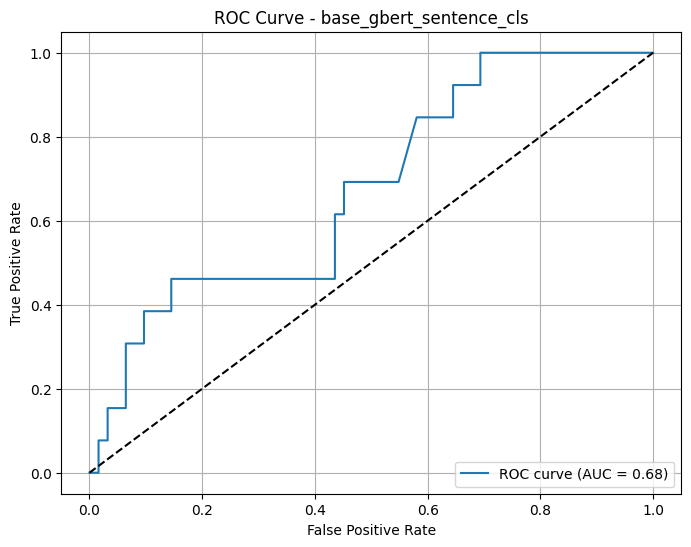

Optimaler Threshold für Cosine Similarity (%): 68.71


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,matched_catalog_id_base_gbert_sentence_cls,match_valid_base_gbert_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,7,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,68,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,8,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,57,True
...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,71,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
72,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,"[0.0441511, -1.2086804, -0.25325823, -1.652079...",46,62.490002,Individuelle Entwicklungen die der Anbieter im...,"Wird geregelt, wem neu entstehende Arbeitserge...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
73,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,"[0.43890297, -0.59373343, -0.5119946, -0.73847...",58,80.110001,Nach Vertragsbeendigung hält der Anbieter die ...,Bleiben die Kundendaten nach Vertragsende für ...,Exit-Strategien_und_Datenportabilität,59,True


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([58, 17]))


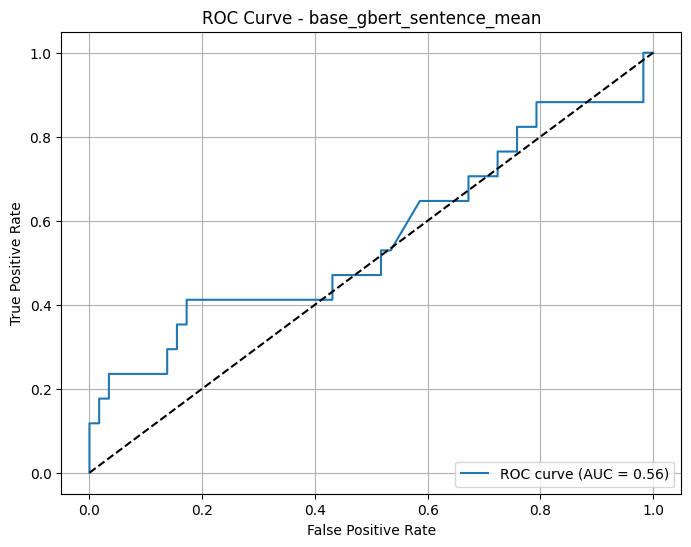

Optimaler Threshold für Cosine Similarity (%): 63.85


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,matched_catalog_id_base_gbert_sentence_cls,match_valid_base_gbert_sentence_cls,section_em_base_gbert_sentence_mean,matched_example_index_base_gbert_sentence_mean,similarity_percent_base_gbert_sentence_mean,matched_example_text_base_gbert_sentence_mean,matched_example_topic_base_gbert_sentence_mean,matched_paragraph_base_gbert_sentence_mean,matched_catalog_id_base_gbert_sentence_mean,match_valid_base_gbert_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,7,True,"[-0.6960519, -0.28822985, 0.079094365, 0.50897...",26,67.730003,Mit der Abnahme der Gesamtleistung durch den K...,Werden die Folgen der Abnahme beschrieben (z.B...,Abnahmeprozesse,27,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,68,True,"[0.14486215, 0.28798917, 0.09911744, 0.5747353...",69,75.739998,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,70,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False,"[0.2790482, 0.16739431, 0.13492543, 0.43298885...",18,71.739998,Erkennt eine Partei dass vereinbarte Termine n...,Gibt es vertragliche Regelungen für den Fall v...,Projektzeitplan_und_Meilensteine,19,True
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,8,True,"[0.240098, -0.057274975, -0.035985548, 0.44854...",18,80.209999,Erkennt eine Partei dass vereinbarte Termine n...,Gibt es vertragliche Regelungen für den Fall v...,Projektzeitplan_und_Meilensteine,19,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,57,True,"[-0.032245506, 0.35046673, -0.19924572, 0.3732...",69,70.099998,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,70,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,71,True,"[0.045716405, 0.6553385, -0.068971016, 0.04350...",18,74.010002,Erkennt eine Partei dass vereinbarte Termine n...,Gibt es vertragliche Regelungen für den Fall v...,Projektzeitplan_und_Meilensteine,19,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False,"[0.104960375, 0.23297177, -0.08886567, 0.16197.

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([55, 20]))


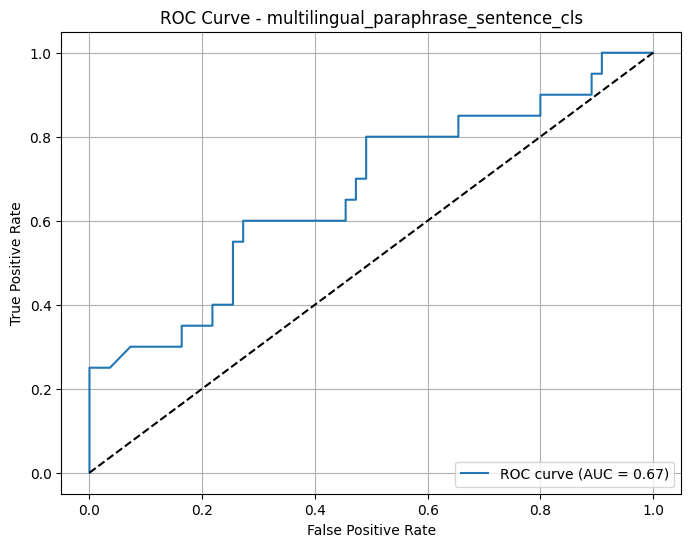

Optimaler Threshold für Cosine Similarity (%): 76.70


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_base_gbert_sentence_mean,match_valid_base_gbert_sentence_mean,section_em_multilingual_paraphrase_sentence_cls,matched_example_index_multilingual_paraphrase_sentence_cls,similarity_percent_multilingual_paraphrase_sentence_cls,matched_example_text_multilingual_paraphrase_sentence_cls,matched_example_topic_multilingual_paraphrase_sentence_cls,matched_paragraph_multilingual_paraphrase_sentence_cls,matched_catalog_id_multilingual_paraphrase_sentence_cls,match_valid_multilingual_paraphrase_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,27,True,"[0.0056744404, 0.18965931, 0.024314873, 0.1840...",69,79.169998,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,70,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,70,True,"[0.047811296, 0.010826666, -0.14551313, -0.113...",64,83.870003,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,65,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,19,True,"[0.2593842, -0.34721622, -0.12384396, -0.10449...",28,74.930000,Supportfälle werden wie folgt priorisiert Krit...,Sind Reaktions- und Lösungszeiten für Supportf...,Service-Level-Agreements_(SLAs),-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,19,True,"[0.13379145, -0.026728496, -0.13647327, 0.0504...",7,77.470001,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,8,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,70,True,"[-0.033014245, -0.21105072, 0.09513073, -0.288...",27,73.919998,Der Anbieter sichert eine Verfügbarkeit des Cl...,Wird eine Mindestverfügbarkeit des SaaS-Dienst...,Service-Level-Agreements_(SLAs),-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,19,True,"[0.12932575, 0.03334893, -0.18412879, -0.22485...",7,81.809998,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,8,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"En

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([49, 26]))


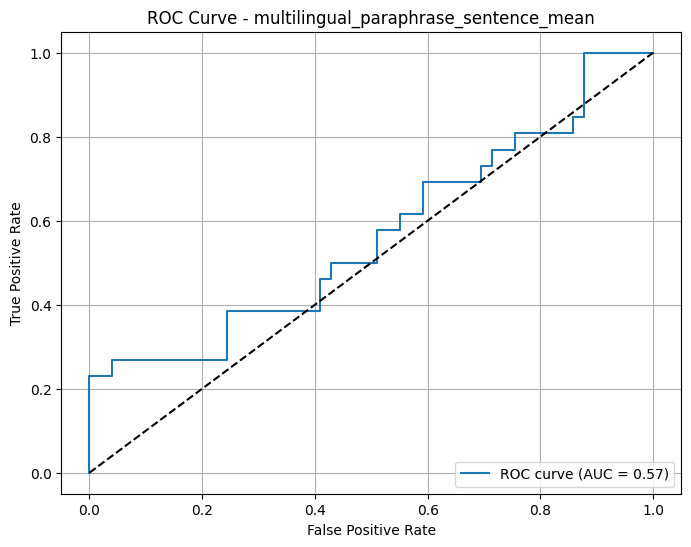

Optimaler Threshold für Cosine Similarity (%): 49.85


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_multilingual_paraphrase_sentence_cls,match_valid_multilingual_paraphrase_sentence_cls,section_em_multilingual_paraphrase_sentence_mean,matched_example_index_multilingual_paraphrase_sentence_mean,similarity_percent_multilingual_paraphrase_sentence_mean,matched_example_text_multilingual_paraphrase_sentence_mean,matched_example_topic_multilingual_paraphrase_sentence_mean,matched_paragraph_multilingual_paraphrase_sentence_mean,matched_catalog_id_multilingual_paraphrase_sentence_mean,match_valid_multilingual_paraphrase_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,70,True,"[-0.23610508, 0.20052604, -0.12860887, 0.13919...",69,66.110001,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,70,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,65,True,"[-0.09291045, 0.12644467, -0.30482224, -0.0664...",64,77.269997,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,65,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[0.1161611, 0.029475981, 0.07503341, 0.1012989...",28,48.220001,Supportfälle werden wie folgt priorisiert Krit...,Sind Reaktions- und Lösungszeiten für Supportf...,Service-Level-Agreements_(SLAs),-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,8,True,"[-0.039549287, 0.11985772, -0.1673822, 0.00856...",7,65.470001,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,8,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,-99,False,"[-0.13719161, 0.06946114, -0.16721752, -0.1689...",69,69.849998,Endet der Vertrag vor Ablauf eines bereits im ...,"Ist geregelt, was mit vorausbezahlten Gebühren...",Vertragslaufzeit_und_Kündigung,70,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,8,True,"[-0.07078281, 0.11598501, -0.22636026, -0.1819...",67,82.989998,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,68,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den

Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([71,  4]))


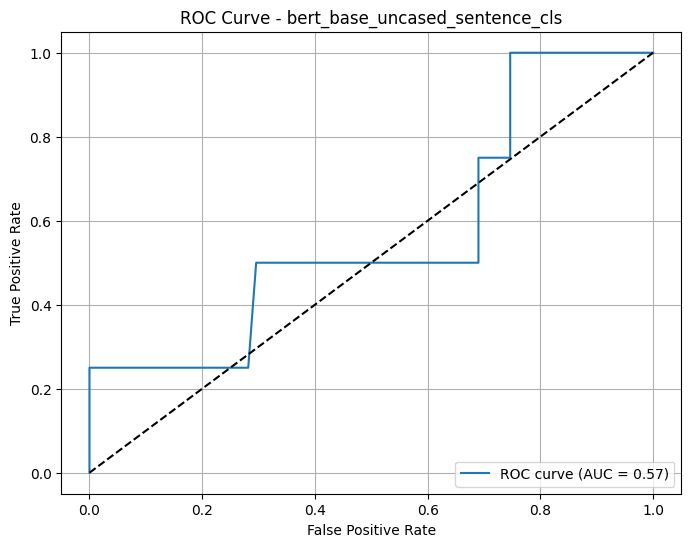

Optimaler Threshold für Cosine Similarity (%): 95.38


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_multilingual_paraphrase_sentence_mean,match_valid_multilingual_paraphrase_sentence_mean,section_em_bert_base_uncased_sentence_cls,matched_example_index_bert_base_uncased_sentence_cls,similarity_percent_bert_base_uncased_sentence_cls,matched_example_text_bert_base_uncased_sentence_cls,matched_example_topic_bert_base_uncased_sentence_cls,matched_paragraph_bert_base_uncased_sentence_cls,matched_catalog_id_bert_base_uncased_sentence_cls,match_valid_bert_base_uncased_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,70,True,"[-0.48365188, 0.37736478, -0.17439969, -0.3041...",60,97.269997,Die Haftung des Anbieters aus und im Zusammenh...,Ist die Haftung der Höhe nach begrenzt (z.B. a...,Haftung_und_Gewährleistung,61,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,65,True,"[-0.5209381, 0.68602806, 0.073435724, -0.24707...",24,98.040001,Verweigert der Kunde die Abnahme wegen erhebli...,"Ist geregelt, was passiert, wenn bei der Abnah...",Abnahmeprozesse,25,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-0.5704126, 0.57907605, -0.24411893, -0.11313...",47,95.650002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,8,True,"[-0.45583782, 0.4538842, 0.01820729, -0.390017...",67,96.019997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,68,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,70,True,"[-0.3433063, 0.42301244, 0.02336425, -0.384284...",5,96.309998,Die monatliche Nutzungsgebühr ist für die erst...,Enthält der Vertrag Regelungen zur Preisänderu...,Projektkosten_und_Zahlungsmodalitäten,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,68,True,"[-0.3641358, 0.77947843, -0.06290907, -0.23495...",50,97.660004,Der Anbieter ist berechtigt maximal einmal pro...,"Hat der Anbieter das Recht, die vertragskonfor...",Rechte_und_Pflichten_der_Vertragsparteien,51,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag e

Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([66,  9]))


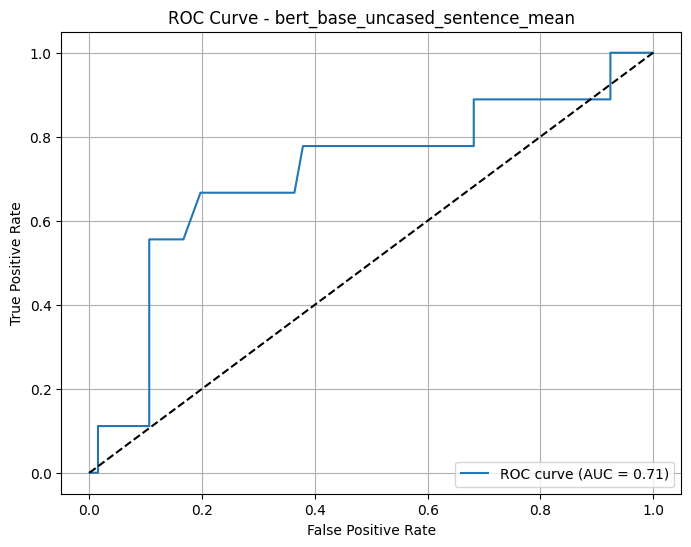

Optimaler Threshold für Cosine Similarity (%): 97.27


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_bert_base_uncased_sentence_cls,match_valid_bert_base_uncased_sentence_cls,section_em_bert_base_uncased_sentence_mean,matched_example_index_bert_base_uncased_sentence_mean,similarity_percent_bert_base_uncased_sentence_mean,matched_example_text_bert_base_uncased_sentence_mean,matched_example_topic_bert_base_uncased_sentence_mean,matched_paragraph_bert_base_uncased_sentence_mean,matched_catalog_id_bert_base_uncased_sentence_mean,match_valid_bert_base_uncased_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,61,True,"[-0.6638517, 0.04017214, 0.15503876, -0.148629...",54,96.029999,Für jede vereinbarte Leistungsänderung wird ei...,"Wird gefordert, dass bei jeder genehmigten Änd...",Änderungsmanagement,-99,False
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,25,True,"[-0.65416014, 0.10622122, 0.29916748, -0.01544...",47,98.239998,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,48,True,"[-0.5428568, 0.11917449, 0.37064618, -0.070138...",47,96.290001,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,68,True,"[-0.65768206, 0.11510661, 0.2869197, -0.024685...",47,97.559998,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,6,True,"[-0.49030626, 0.06744515, 0.23019606, -0.06512...",50,96.889999,Der Anbieter ist berechtigt maximal einmal pro...,"Hat der Anbieter das Recht, die vertragskonfor...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,51,True,"[-0.61554146, 0.29096952, 0.16925265, 0.040406...",70,98.150002,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,71,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Ford

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([68,  7]))


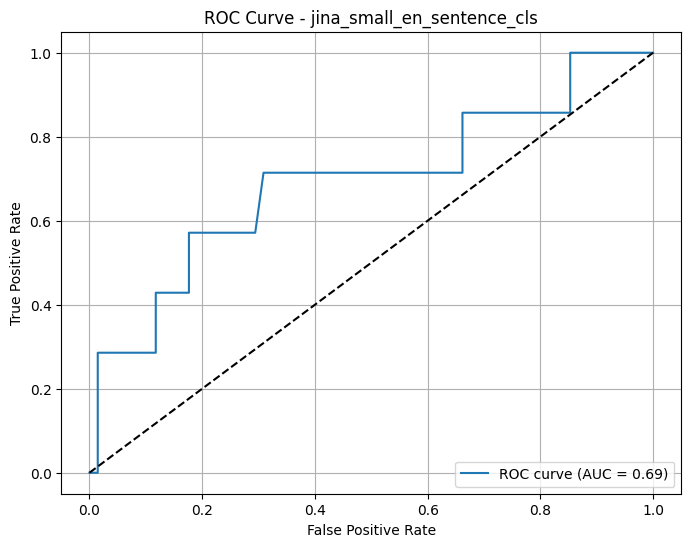

Optimaler Threshold für Cosine Similarity (%): 84.77


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_bert_base_uncased_sentence_mean,match_valid_bert_base_uncased_sentence_mean,section_em_jina_small_en_sentence_cls,matched_example_index_jina_small_en_sentence_cls,similarity_percent_jina_small_en_sentence_cls,matched_example_text_jina_small_en_sentence_cls,matched_example_topic_jina_small_en_sentence_cls,matched_paragraph_jina_small_en_sentence_cls,matched_catalog_id_jina_small_en_sentence_cls,match_valid_jina_small_en_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-0.5677809, -1.7036784, -0.840641, -0.1103858...",3,89.510002,Alle Preise verstehen sich in Euro zuzüglich g...,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",Projektkosten_und_Zahlungsmodalitäten,4,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,48,True,"[-1.3265457, -1.2070924, -0.7980194, -0.199686...",75,91.250000,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,76,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.2200058, -0.7827039, -0.84988606, -0.05158...",47,84.000000,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,48,True,"[-1.6033083, -2.0628526, 0.050755206, -0.19393...",47,85.309998,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,-99,False,"[-1.0216601, -1.7396556, -1.0957087, 0.0110041...",40,88.489998,Auf Verlangen des Kunden weist der Anbieter di...,"Hat der Kunde das Recht, die Einhaltung der Si...",Datenschutz_und_Informationssicherheit,41,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,71,True,"[-1.5565696, -0.8990796, -0.7064297, -0.201462...",37,89.879997,Der Anbieter wird den Kunden unverzüglich schr...,"Verpflichtet sich der Anbieter, Sicherheitsvor...",Datenschutz_und_Informationssicherheit,38,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag ein

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.56it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([70,  5]))


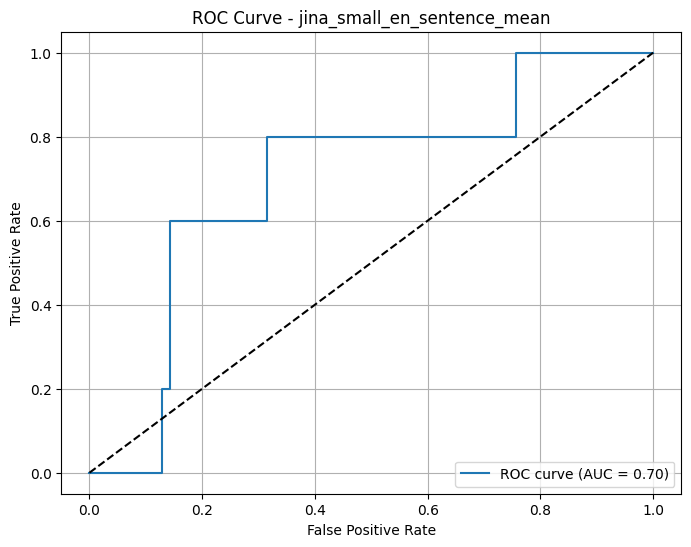

Optimaler Threshold für Cosine Similarity (%): 90.03


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_small_en_sentence_cls,match_valid_jina_small_en_sentence_cls,section_em_jina_small_en_sentence_mean,matched_example_index_jina_small_en_sentence_mean,similarity_percent_jina_small_en_sentence_mean,matched_example_text_jina_small_en_sentence_mean,matched_example_topic_jina_small_en_sentence_mean,matched_paragraph_jina_small_en_sentence_mean,matched_catalog_id_jina_small_en_sentence_mean,match_valid_jina_small_en_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,4,True,"[-0.76862687, -1.1392056, -0.38628694, 0.28578...",15,87.800003,Der Projektzeitplan wird als Anlage 2 festgesc...,Gibt es einen schriftlichen Projektzeitplan mi...,Projektzeitplan_und_Meilensteine,-99,False
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,76,True,"[-1.0930728, -0.8965573, -0.4915765, -0.351139...",75,90.669998,Keine der Parteien haftet für die Nichterfüllu...,"Gibt es eine Regelung, was gilt bei höherer Ge...",Sonstige_wichtige_Klauseln,76,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.1415553, -0.61684823, -0.64163095, 0.09819...",47,84.320000,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,48,True,"[-1.311616, -1.4060552, -0.074007295, -0.26084...",47,88.430000,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,41,True,"[-0.4419912, -1.1864111, -0.57372975, -0.08764...",40,88.709999,Auf Verlangen des Kunden weist der Anbieter di...,"Hat der Kunde das Recht, die Einhaltung der Si...",Datenschutz_und_Informationssicherheit,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,38,True,"[-1.0859042, -0.47057366, -0.28746435, -0.1566...",70,92.570000,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,71,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([73,  2]))


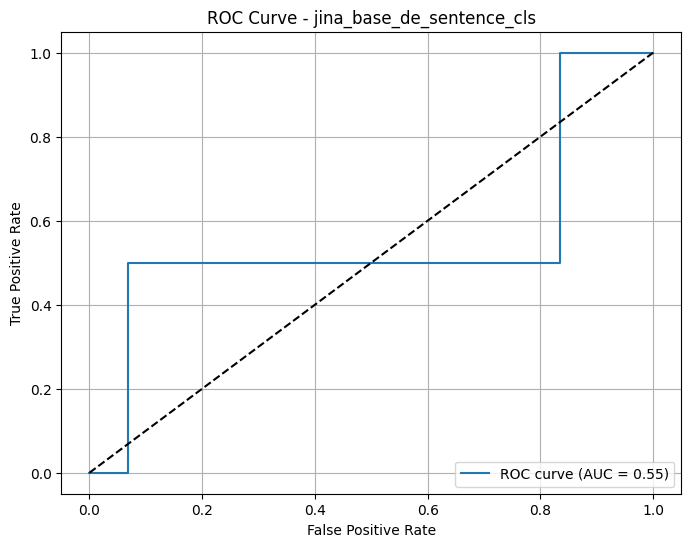

Optimaler Threshold für Cosine Similarity (%): 46.73


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_small_en_sentence_mean,match_valid_jina_small_en_sentence_mean,section_em_jina_base_de_sentence_cls,matched_example_index_jina_base_de_sentence_cls,similarity_percent_jina_base_de_sentence_cls,matched_example_text_jina_base_de_sentence_cls,matched_example_topic_jina_base_de_sentence_cls,matched_paragraph_jina_base_de_sentence_cls,matched_catalog_id_jina_base_de_sentence_cls,match_valid_jina_base_de_sentence_cls
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[0.14527243, 1.1030084, -1.3523102, 1.1778135,...",23,54.560001,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,24,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,76,True,"[-1.3245506, 2.1513078, -1.2868196, 1.461433, ...",58,49.169998,Nach Vertragsbeendigung hält der Anbieter die ...,Bleiben die Kundendaten nach Vertragsende für ...,Exit-Strategien_und_Datenportabilität,59,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.2026117, 1.8651327, 0.34122914, -0.4705357...",37,39.849998,Der Anbieter wird den Kunden unverzüglich schr...,"Verpflichtet sich der Anbieter, Sicherheitsvor...",Datenschutz_und_Informationssicherheit,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-1.5356005, 0.3735422, -1.1966293, 1.7395114,...",44,39.750000,Der Anbieter setzt für dieses Projekt Frau Mül...,Gibt es Vorgaben zur personellen Kontinuität b...,Rechte_und_Pflichten_der_Vertragsparteien,-99,False
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,-99,False,"[1.1312462, 1.3807071, 0.57179195, 1.039338, -...",52,49.419998,Wünscht der Kunde Änderungen des vereinbarten ...,Gibt es einen formalen Prozess für Leistungsän...,Änderungsmanagement,53,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,71,True,"[-1.6049898, -0.7342096, 0.059129685, 0.353797...",37,48.230000,Der Anbieter wird den Kunden unverzüglich schr...,"Verpflichtet sich der Anbieter, Sicherheitsvor...",Datenschutz_und_Informationssicherheit,38,True
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_de

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

int64
int64
Verteilung der Klassen in y_true:
(array([0, 1]), array([72,  3]))


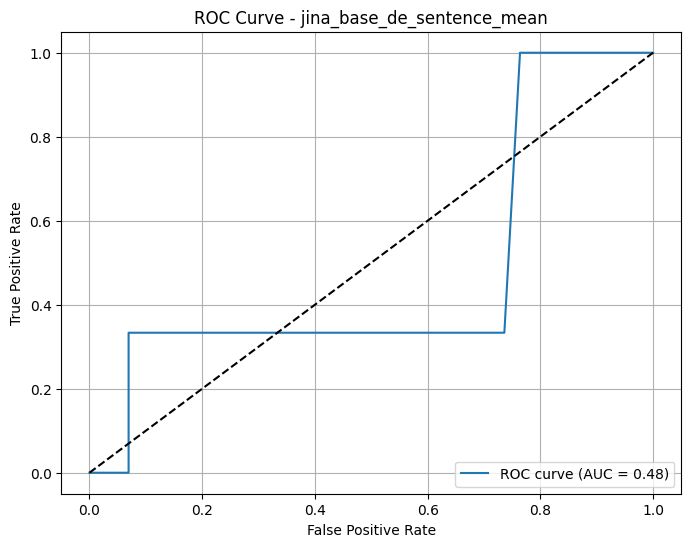

Optimaler Threshold für Cosine Similarity (%): 51.71


,contract,paragraph,section,clean_section_content,section_em_base_gbert_sentence_cls,matched_example_index_base_gbert_sentence_cls,similarity_percent_base_gbert_sentence_cls,matched_example_text_base_gbert_sentence_cls,matched_example_topic_base_gbert_sentence_cls,matched_paragraph_base_gbert_sentence_cls,...,matched_catalog_id_jina_base_de_sentence_cls,match_valid_jina_base_de_sentence_cls,section_em_jina_base_de_sentence_mean,matched_example_index_jina_base_de_sentence_mean,similarity_percent_jina_base_de_sentence_mean,matched_example_text_jina_base_de_sentence_mean,matched_example_topic_jina_base_de_sentence_mean,matched_paragraph_jina_base_de_sentence_mean,matched_catalog_id_jina_base_de_sentence_mean,match_valid_jina_base_de_sentence_mean
0,2,§ 7,(1),zahlungszeitraum und höhe der vergütung richte...,"[0.5661153, -0.94223493, -0.03465558, -0.52522...",6,69.250000,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,...,24,True,"[0.1856915, 0.78971064, -1.1697305, 1.1179487,...",23,54.540001,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,24,True
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,"[0.26419818, -0.3153873, 0.23275022, -0.169983...",67,71.199997,Nach Ablauf der Mindestlaufzeit von 24 Monaten...,"Ist geregelt, ob sich der Vertrag automatisch ...",Vertragslaufzeit_und_Kündigung,...,59,True,"[-1.1317749, 2.0514202, -1.3758327, 2.2041261,...",38,58.029999,Sämtliche Daten die der Kunde im Rahmen der Nu...,"Bleibt klargestellt, dass alle vom Kunden stam...",Datenschutz_und_Informationssicherheit,39,True
2,4,3.,3.2,support und sla sap erbringt support für den c...,"[0.6799012, -0.85286653, 0.14725323, -0.703191...",47,64.089996,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,...,-99,False,"[-1.1516305, 1.2254078, 0.65628487, 0.8047882,...",61,49.880001,Der Anbieter haftet nicht für indirekte Schäde...,Sind bestimmte Schäden von der Haftung ausgesc...,Haftung_und_Gewährleistung,-99,False
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,"[0.61529243, -0.40853298, -0.37172544, -0.1799...",7,82.139999,Gerät der Kunde mit einer Zahlung in Verzug so...,Sind Konsequenzen bei Zahlungsverzug geregelt ...,Projektkosten_und_Zahlungsmodalitäten,...,-99,False,"[-1.2339333, -0.18492782, -1.2500882, 0.936963...",1,44.299999,Der Kunde zahlt eine monatliche Pauschale von ...,Ist das Vergütungsmodell eindeutig festgelegt ...,Projektkosten_und_Zahlungsmodalitäten,-99,False
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,"[-0.32557803, -0.19167474, -0.16187264, -0.394...",56,75.570000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,...,53,True,"[0.2743125, 1.2433729, 0.62818635, 1.4529153, ...",52,54.759998,Wünscht der Kunde Änderungen des vereinbarten ...,Gibt es einen formalen Prozess für Leistungsän...,Änderungsmanagement,53,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,"[0.54024714, -0.37876326, 0.6823356, -0.988752...",70,73.099998,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,...,38,True,"[-1.6489975, -0.5619577, -0.06015328, 0.692927...",12,51.369999,Im Leistungsumfang enthalten ist die Entwicklu...,Werden geplante Schnittstellen zu Dritt-System...,Leistungsbeschreibung_und_Deliverables,-99,False
71,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,"[0.52609515, -0.1273699, 0.15742014, -1.065668...",47,63.490002,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragspartei

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
df_to_match = df_labeled[["contract","paragraph","section","clean_section_content"]]
df_true_match = df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
df_true_match.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
display(df_true_match)
df_true_match["true_catalog_id"] = df_true_match["true_catalog_id"].astype(int)
cols = ["contract","paragraph","section","clean_section_content"]



for model_name in models_dict:
    model_selected = models_dict[model_name]
    df_to_match = embed_text_column(df_to_match, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
    cat = embed_text_column(catalogue, text_column = "example", model = model_selected, target_column = "emb")
    cols.append(f"section_em_{model_name}")
    df_to_match  = df_to_match[cols]
    X = np.vstack(df_to_match[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
    df_to_match[f"similarity_percent_{model_name}"] = best_match_score
    df_to_match[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
    df_to_match[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
    df_to_match[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values
    df_to_match[f"matched_catalog_id_{model_name}"] = cat.loc[best_match_idx, "catalog_id"].values

    print(df_true_match["true_catalog_id"].dtype)
    print(df_to_match[f"matched_catalog_id_{model_name}"].dtype)    
    

    y_true = (df_true_match["true_catalog_id"].values == df_to_match[f"matched_catalog_id_{model_name}"].values).astype(int)
    y_scores = df_to_match[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1
    print("Verteilung der Klassen in y_true:")
    print(np.unique(y_true, return_counts=True))


    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    # Optimaler Threshold = max(tpr - fpr)
    custom_score = tpr - 0.5 * fpr
    optimal_idx = np.argmax(custom_score)
    optimal_threshold = thresholds[optimal_idx]
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df_to_match.loc[~df_to_match[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    cols = list(df_to_match.columns)
    display(df_to_match)

    










In [ ]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

tab_contents = []

for model_name in models_dict:
    output = widgets.Output()
    with output:
        model_selected = models_dict[model_name]
        df_to_match = embed_text_column(df_to_match, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
        cat = embed_text_column(catalogue, text_column = "example", model = model_selected, target_column = "emb")
        cols.append(f"section_em_{model_name}")
        df_to_match  = df_to_match[cols]
        X = np.vstack(df_to_match[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
        Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

        # Cosine Similarity: alle Kombinationen
        similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
        similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

        best_match_idx = similarity_matrix.argmax(axis=1)
        best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

        # Ergebnisse anhängen
        df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
        df_to_match[f"similarity_percent_{model_name}"] = best_match_score
        df_to_match[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
        df_to_match[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
        df_to_match[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values
        df_to_match[f"matched_catalog_id_{model_name}"] = cat.loc[best_match_idx, "catalog_id"].values

        print(df_true_match["true_catalog_id"].dtype)
        print(df_to_match[f"matched_catalog_id_{model_name}"].dtype)    
        

        y_true = (df_true_match["true_catalog_id"].values == df_to_match[f"matched_catalog_id_{model_name}"].values).astype(int)
        y_scores = df_to_match[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1
        print("Verteilung der Klassen in y_true:")
        print(np.unique(y_true, return_counts=True))


        # ROC-Kurve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {model_name}')
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.show()

        display(df_to_match)  # die jeweilige Ergebnistabelle

    tab_contents.append((model_name, output))

# Tabs erzeugen
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)


In [ ]:
df_matched = df_to_match
from sklearn.metrics import accuracy_score, f1_score, classification_report

results = []

for model_name in models_dict:
    print(f"### {model_name} ###")
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    print("Accuracy:", accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))
    print("F1 (macro):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'))
    print("F1 (weighted):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'))
    print("\nReport:\n", classification_report(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))

    print(f"### {model_name} ###")

    results.append({
            "model": model_name,
            "recall (macro)": recall_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'),
            "recall (weighted)": recall_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'),
            "Accuracy": accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]),
            "F1 (macro)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'),
            "F1 (weighted)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted')
        })


### base_gbert_sentence_cls ###
Accuracy: 0.17333333333333334
F1 (macro): 0.13184079601990048
F1 (weighted): 0.14888888888888888

Report:
               precision    recall  f1-score   support

         -99       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00       

/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classific

[  7  68 -99   8  57  36  40  48   6  43  27  62  20  50  28  56  21  49
  17   2  14  47   5  65  24  44  16  52  63  71  59]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


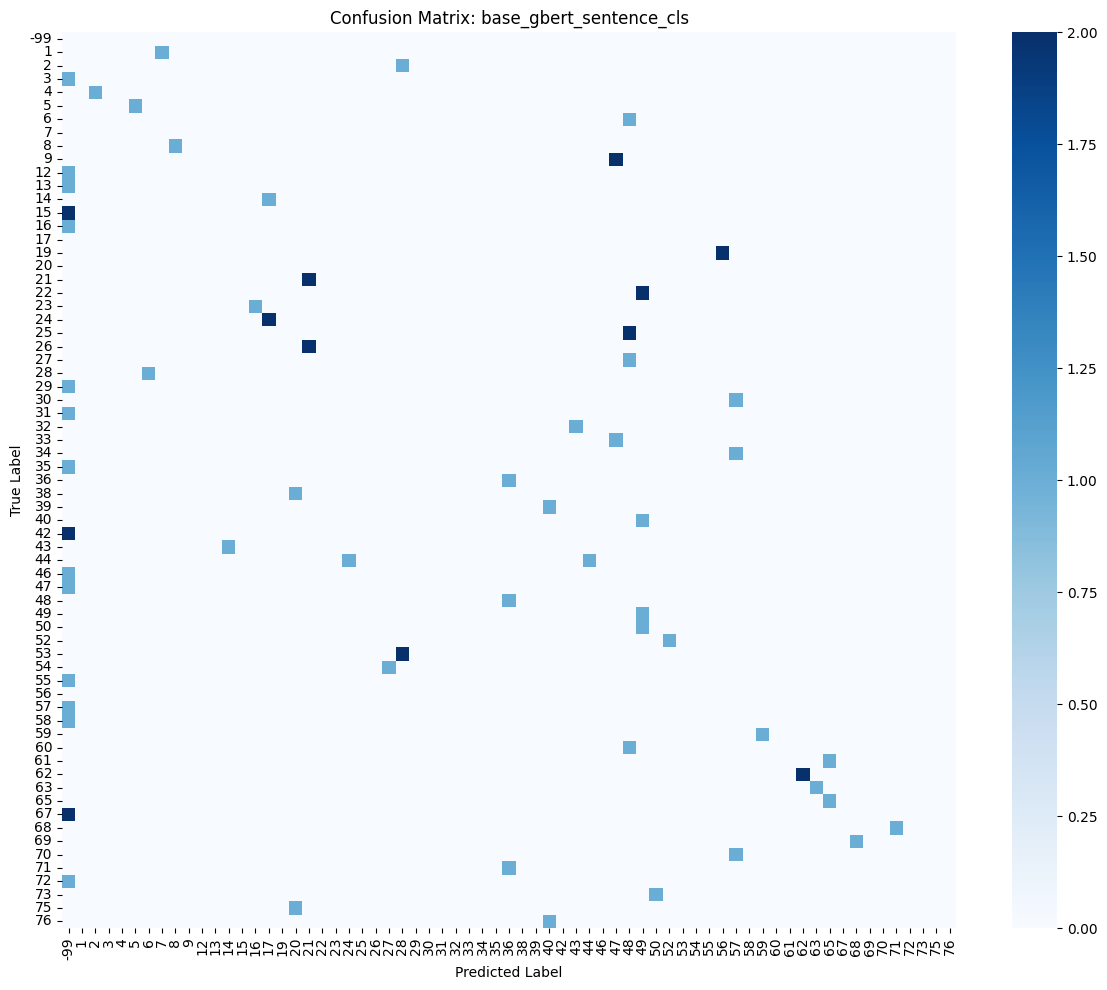

[ 27  70  19  46  54 -99  40  48  36  58  30  53  32  41  62  47  73  56
  21  25   6  43  20  49  57  69  45  44  14  61  52  75  63  59]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


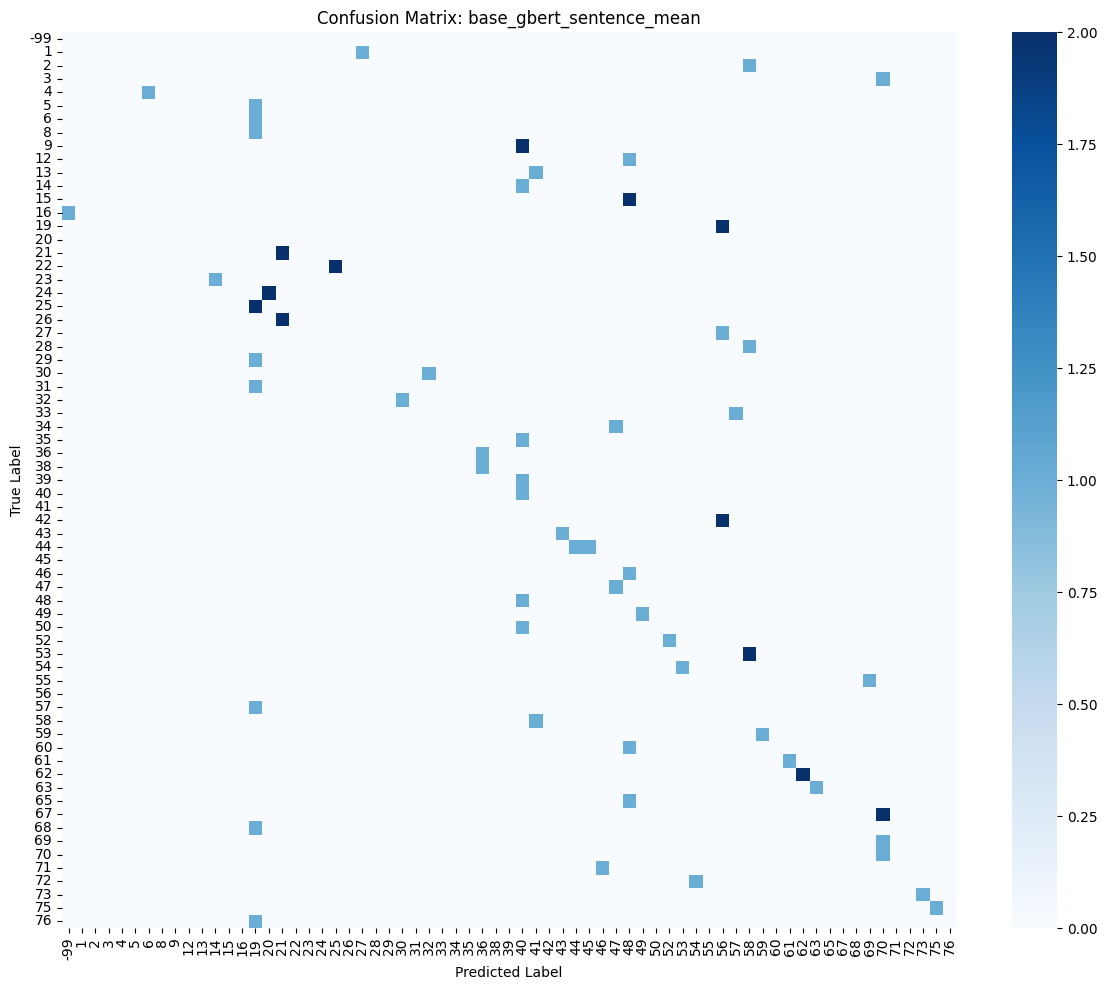

[ 70  65 -99   8  73  40  36  30  54  53  22  47  29  51  44   5  57  46
  75  63  48  31  56  39  76]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


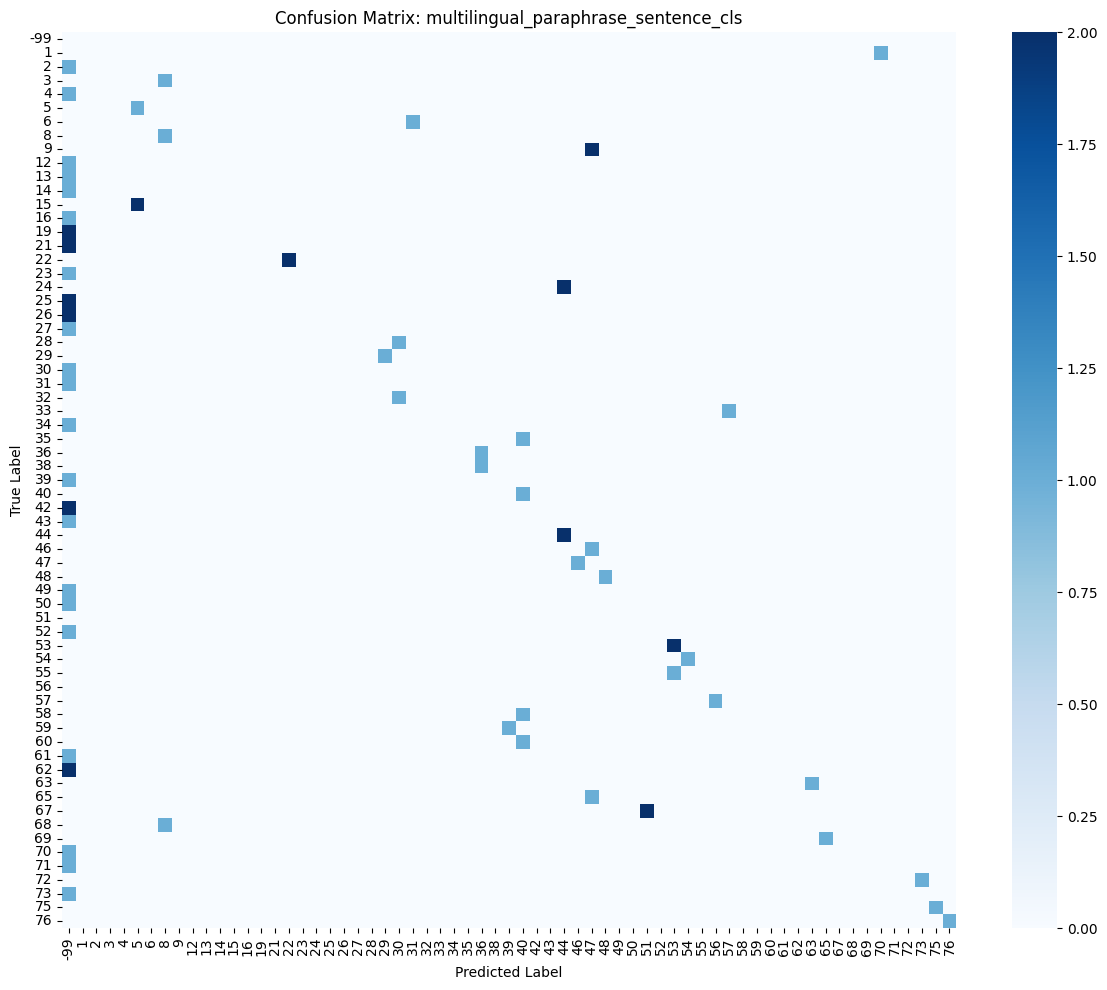

[ 70  65 -99   8  66  73  47  48  36  58  12  30  54  40  32  63  13  62
  53  19  56  25   2   4  43  26  51  20   5  57  55  69  44  52  75  68
  39  76]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


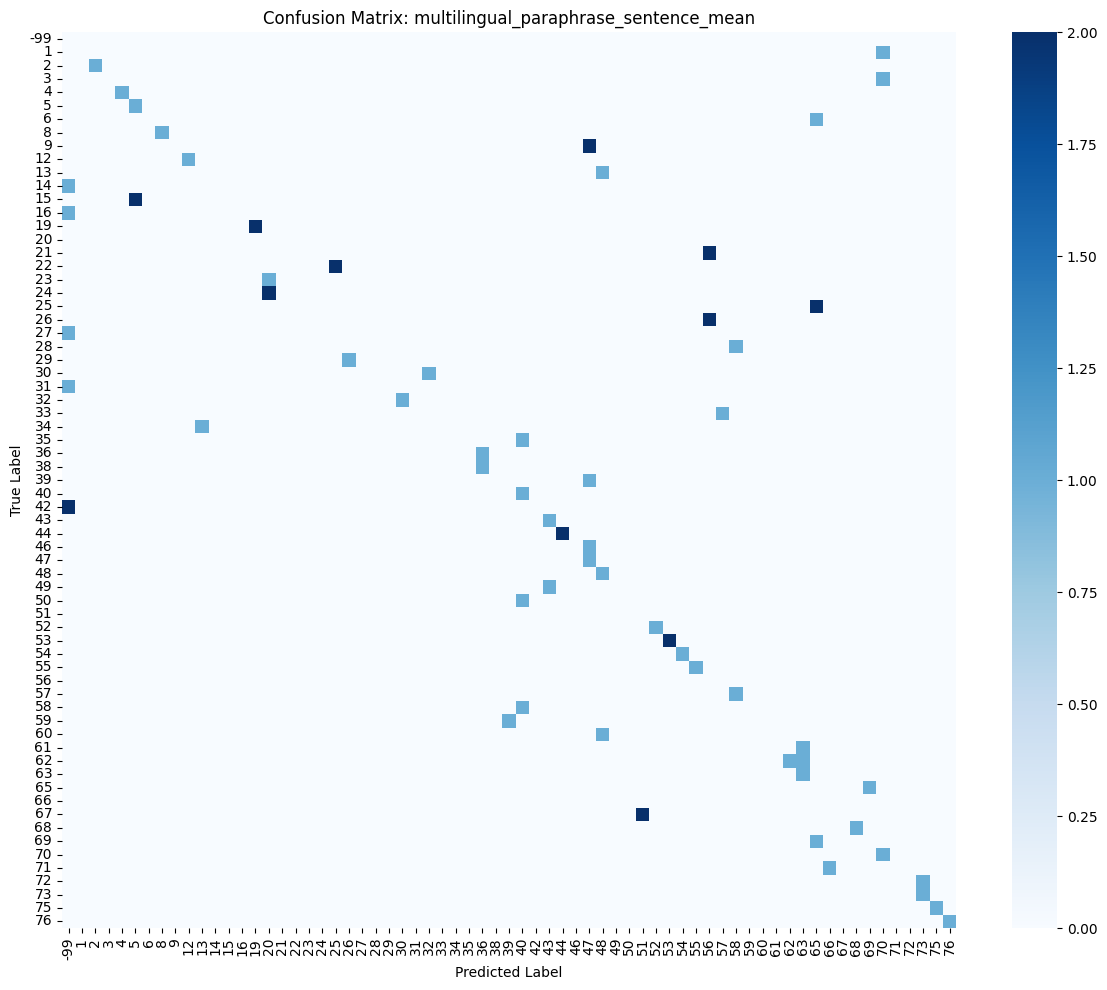

[ 61  25  48  68   6  63  62 -99   5  51  57  42  23  44  72  45  26  58
  35  55   9  65  75  71]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


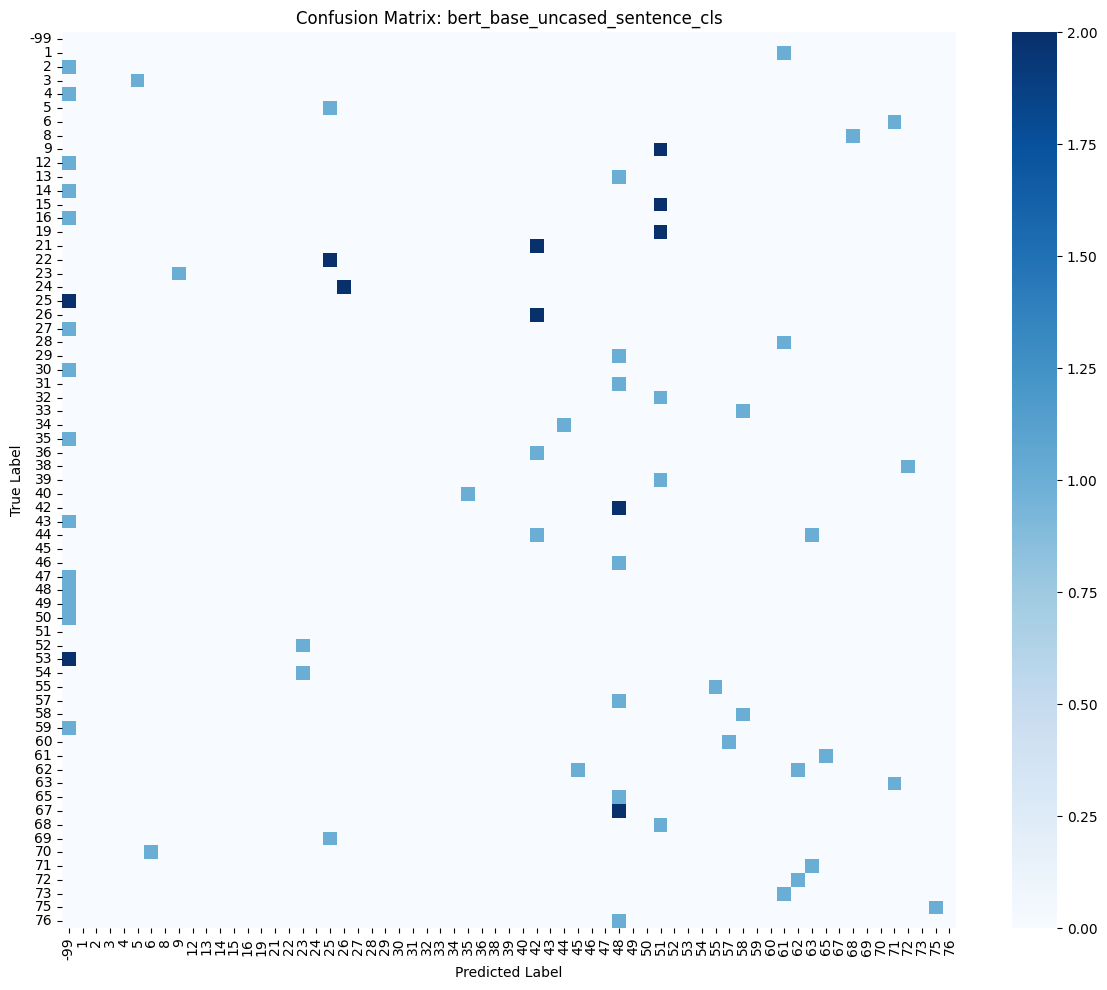

[-99  48  71  55  36  63  30  51  41  40   5  44  75  70  49]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


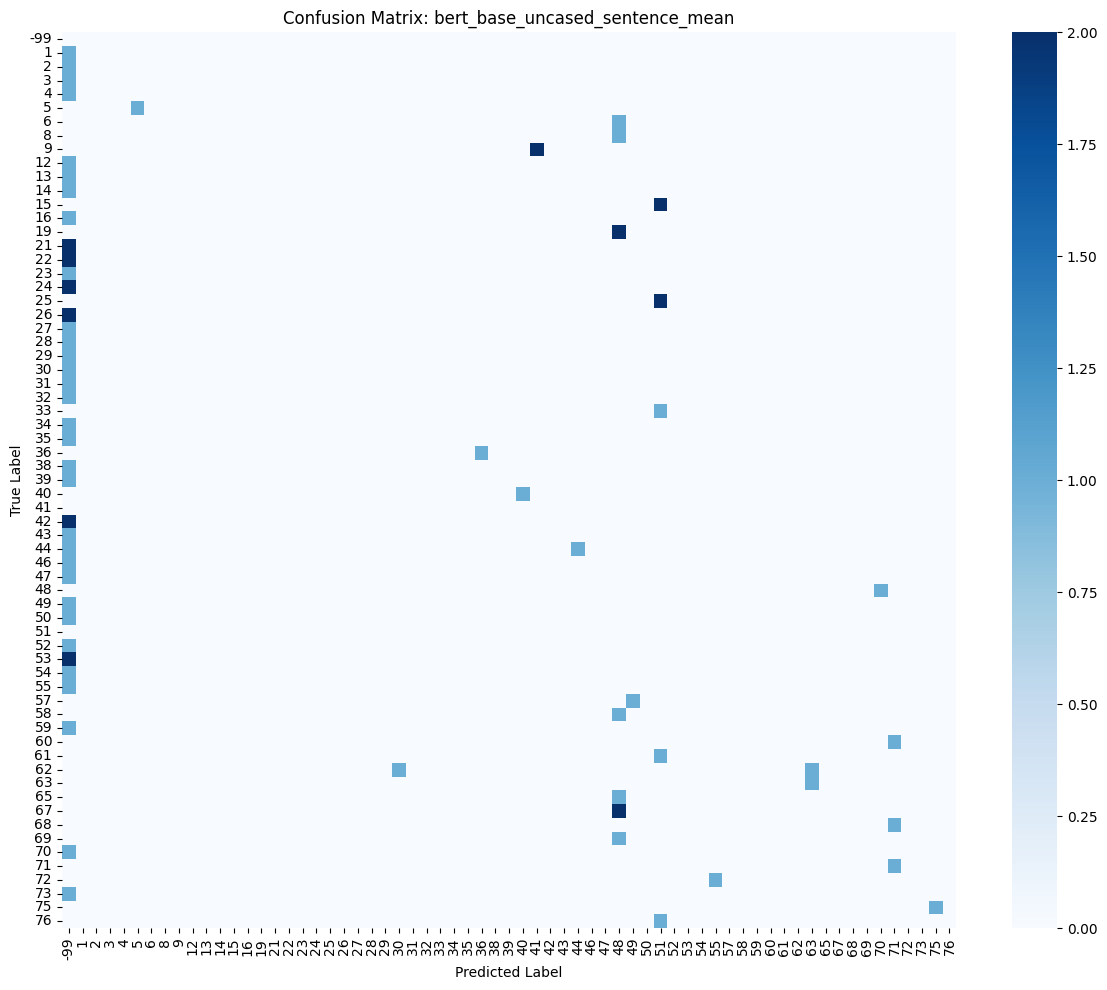

[  4  76 -99  48  41  20  42  65  64  21  44  40  63  24  73  62  54  56
  52  55  71  18   2  19  50  30  45  14  75  57  38]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


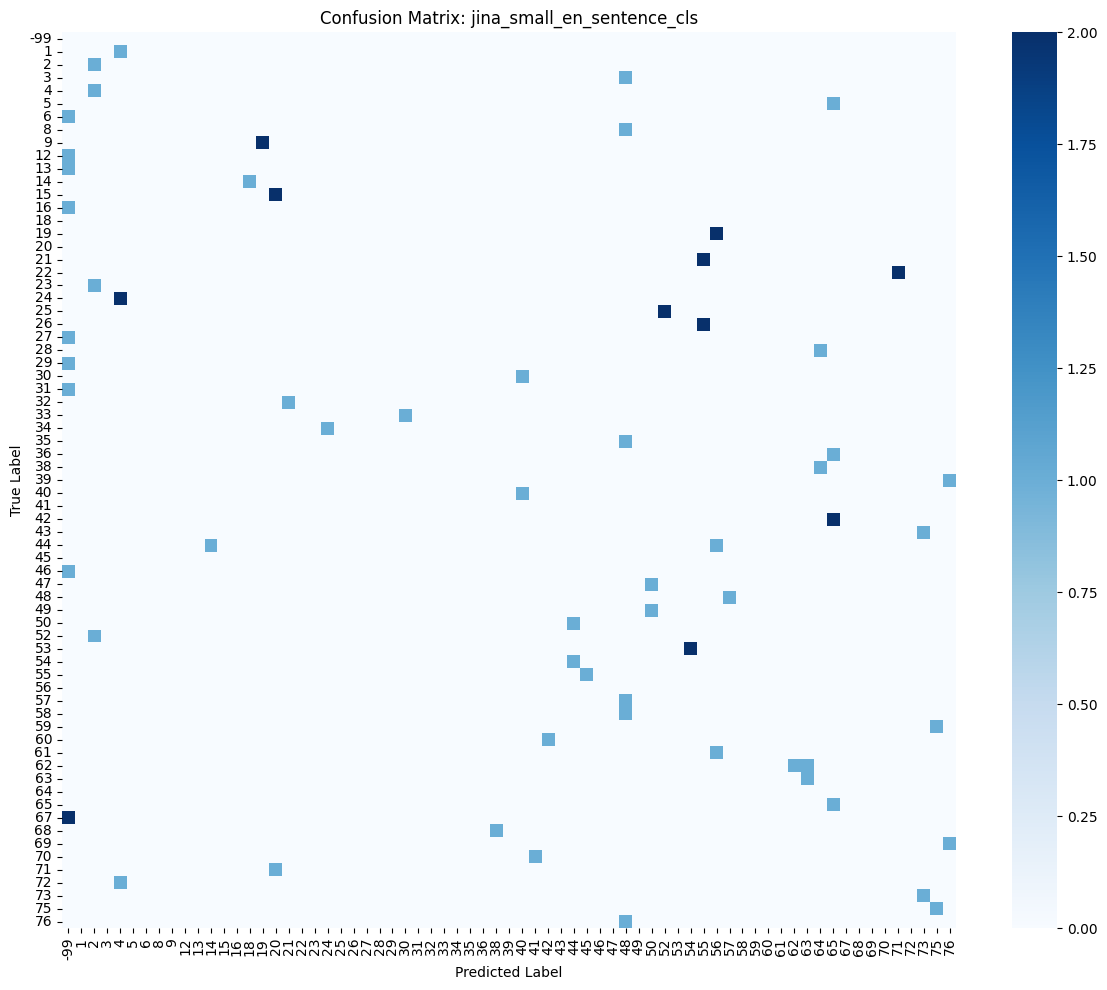

[-99  76  34  42  21  73  62  43  57  66  19  40  51  63  70  71]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


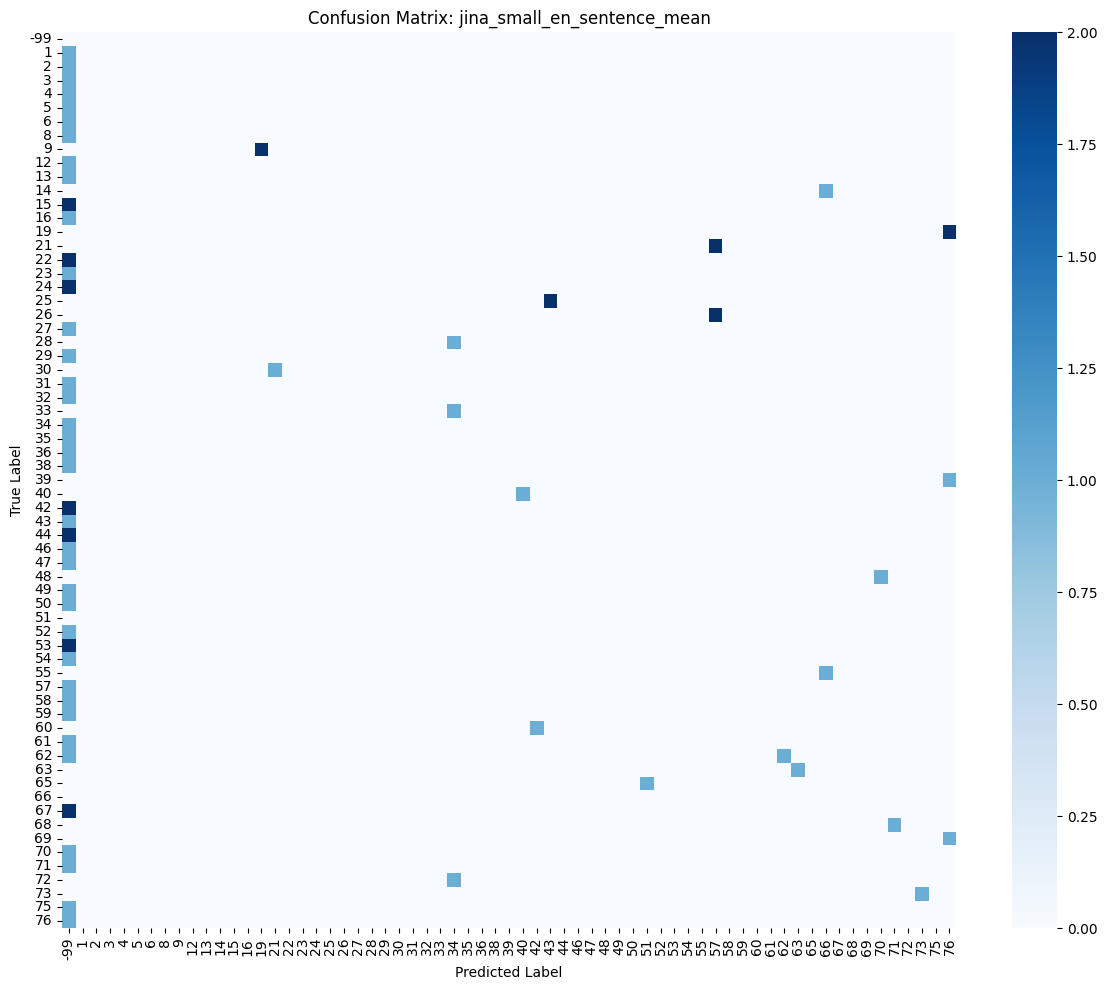

[ 24  59 -99  53   3   1  63  18   5  16  62  56  45  28  71  72  67  13
  22  60  40  10  38  35  26  12   9  55  23]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


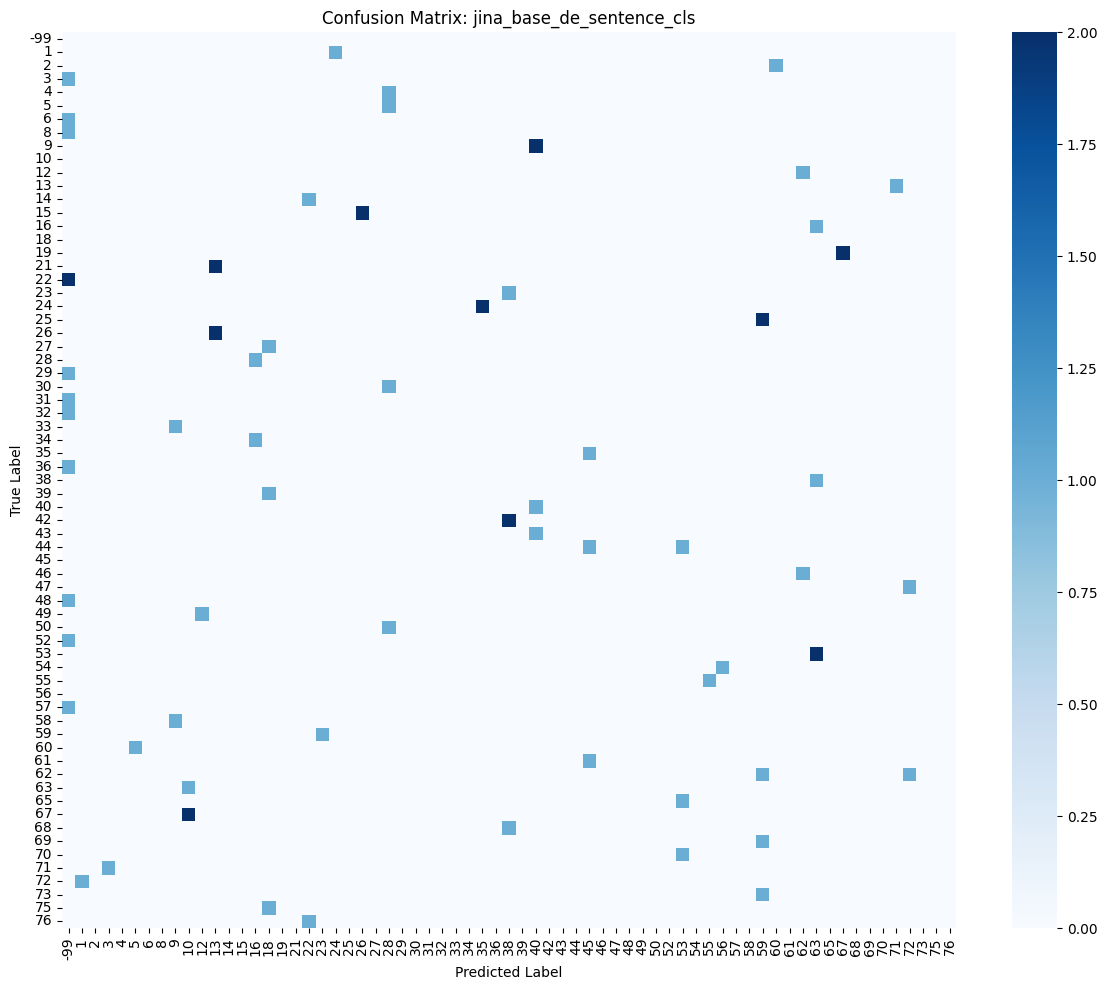

[ 24  39 -99  53   3   1  22  44  66  45  72  55  59  13  63  16  26  62
  60  28  10  40  38  35  12  75   2  15  23  76]


/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")


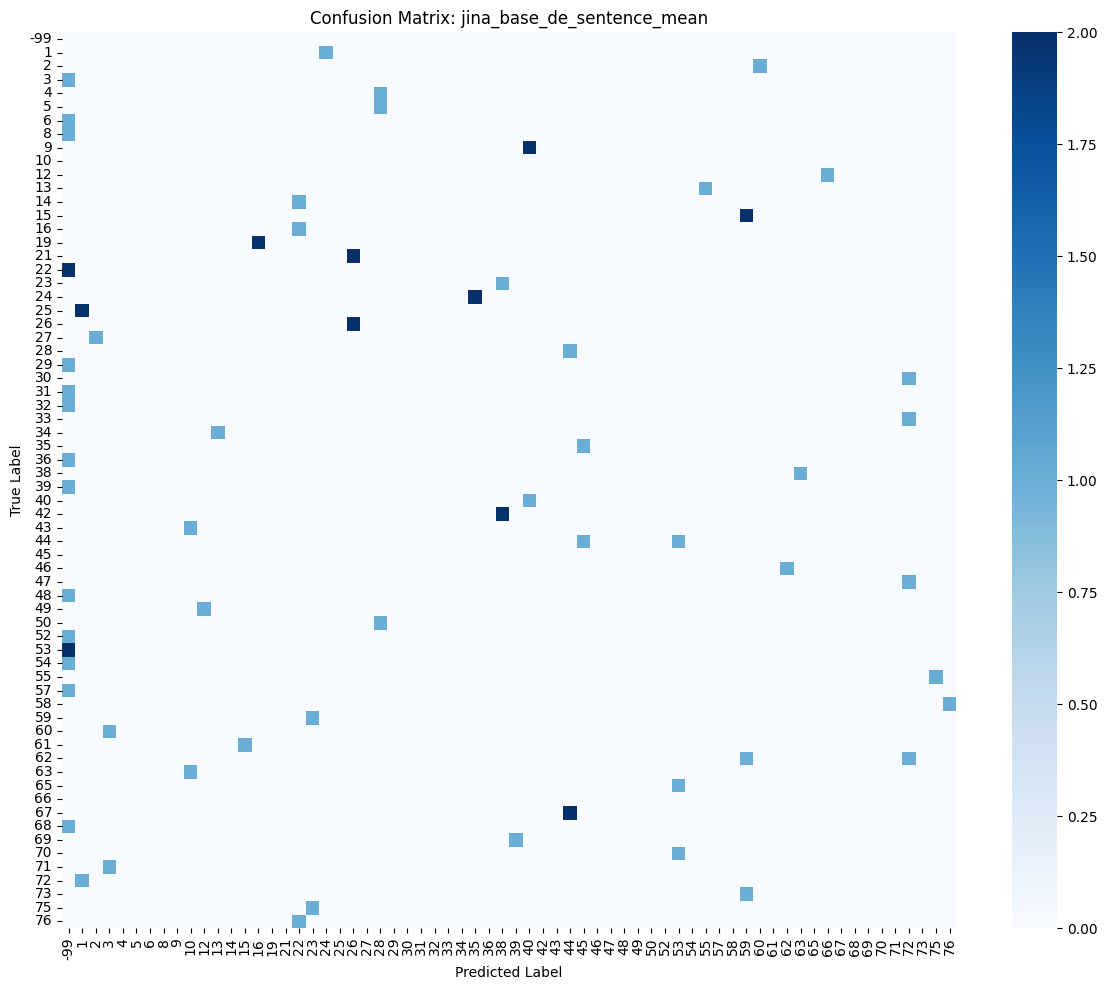

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
for model_name in models_dict:
    # Für bessere Lesbarkeit als np.array
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    y_true = df_true_match["true_catalog_id"]
    y_pred = df_matched_ids[f"matched_catalog_id_{model_name}"]
    print(df_matched_ids[f"matched_catalog_id_{model_name}"].unique())
    # Confusion Matrix berechnen
    all_labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", 
                xticklabels=all_labels, 
                yticklabels=all_labels)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [ ]:

results_df = pd.DataFrame(results).sort_values("F1 (weighted)", ascending=False)
display(results_df)


,model,recall (macro),recall (weighted),Accuracy,F1 (macro),F1 (weighted)
3,multilingual_paraphrase_sentence_mean,0.335821,0.346667,0.346667,0.274627,0.294222
1,base_gbert_sentence_mean,0.216418,0.226667,0.226667,0.182421,0.194074
2,multilingual_paraphrase_sentence_cls,0.200000,0.213333,0.213333,0.162051,0.173333
0,base_gbert_sentence_cls,0.156716,0.173333,0.173333,0.131841,0.148889
5,bert_base_uncased_sentence_mean,0.100000,0.093333,0.093333,0.089744,0.086667
6,jina_small_en_sentence_cls,0.094203,0.093333,0.093333,0.058937,0.063111
7,jina_small_en_sentence_mean,0.053846,0.053333,0.053333,0.056410,0.057778
4,bert_base_uncased_sentence_cls,0.053846,0.053333,0.053333,0.048718,0.048889
9,jina_base_de_sentence_mean,0.030303,0.040000,0.040000,0.017677,0.024444
8,jina_base_de_sentence_cls,0.029851,0.026667,0.026667,0.020896,0.018667
